# TEA algorithm brief tutorial
-Jacob A. Nelson
23 Feb. 2018

Here we will give a brief explanation and example of the Transpiration Estimation Algorithm (TEA). Running this file as an interactive Jupyter script will allow you to test the code to see if TEA is working on your machine.

## Input data

TEA was designed to be used with eddy covariance carbon and energy flux datasets to partitioning gross evapotranspiration (ET) fluxes (derived from latent energy fluxes) into component transpiration (T) and evaporation (E) fluxes. The package assumes that the flux dataset has been already been processed with gap filling and $CO_{2}$ flux partitioning (NEE to GPP and $R_{eco}$). This is the standard format for files downloaded from FLUXNET datasets (http://fluxnet.fluxdata.org/). If your dataset has not had the gap filling and NEE partitioning done, one package (of many) that performs these tasks is the REddyProc package (https://cran.r-project.org/web/packages/REddyProc/index.html).

The basic variables needed are:

timestamp : datetime64[ns] array
    timestamp of all variables in
ET: list or list like
    evapotranspiration (mm hh-1)
GPP: list or list like
    gross primary productivity (umol m-2 s-1)
Tair: list or list like
    air temperature (deg C)
RH: list or list like
    relative humidity (%)
VPD: list or list like
    vapor pressure deficit (hPa)
precip: list or list like
    precipitation (mm hh-1)    
Rg: list or list like
    incoming shortwave radiation (W m-2)
Rg_pot: list or list like
    potential incoming shortwave radiation (W m-2)
u: list or list like
    wind speed (m s-1)

## The tutorial

This tutorial will use the model datasets found in the TestData folder of this package. These datasets are artificial flux datasets which can be used to validate TEA, as well as give a simple dataset with which to practice (such as in this tutorial). We will focus on the TestData/MuSICA_FR-LBr.nc file as it is relatively small, only containing two years. Run times can be lengthy, on the order of hours with datasets on the order of tens of years running on a single processors. Note that the partitioning step can be run in parallel using the multiprocessing package in python.

### build initial dataset

First, we can start by importing the test datset, which will use the xarray package. Xarray keeps files in the NetCDF file format, which we will use to during the partitioning. If you aren't familiar with the NetCDF file format don't panic, as we will rebuild the file using any sort of array or list. We also import numpy which we will use later.

In [1]:
import xarray as xr
import numpy as np

dsIN = xr.open_dataset('TestData/MuSICA_FR-LBr.nc')

Once loaded, we can examine the dataset using:

In [2]:
print(dsIN)

<xarray.Dataset>
Dimensions:    (timestamp: 35040)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 1998-01-01 1998-01-01T00:30:00 ...
Data variables:
    ET         (timestamp) float64 ...
    ET_T       (timestamp) float64 ...
    GPP        (timestamp) float64 ...
    LAI        (timestamp) float64 ...
    RH         (timestamp) float64 ...
    Rg         (timestamp) float64 ...
    Rg_pot     (timestamp) float64 ...
    Tair       (timestamp) float64 ...
    VPD        (timestamp) float64 ...
    precip     (timestamp) float64 ...
    u          (timestamp) float64 ...
Attributes:
    site:             FR-LBr
    Country:          France
    IGBP_class:       ENF
    Climate_class:    Cfb
    Climate_Group:    Temperate
    PFT:              ENF
    Name:             Le Bray (after 6/28/1998)
    Latitude:         44.71709824
    Longitude:        -0.769299984
    Elevation:        61.0
    TimeZone:         1.0
    source:           MuSICA
    source_type:      model
    Pre

Now, if you don't have a nice pre-packaged dataset like this, you can also build one from scratch using the build_dataset function:

In [3]:
from TEA.PreProc import build_dataset

If we check the documentation of build_dataset, we can see the core variables we will need to run the partitioning.

In [4]:
print(build_dataset.__doc__)

build_dataset(timestamp, ET, GPP, RH, Rg, Rg_pot, Tair, VPD, precip, u, OtherVars=None)
    
    build dataset for partitioning
    
    Uses the imput variables to build an xarray dataset which will be used in the partitioning.
    

    Parameters
    ----------
    timestamp : datetime64[ns] array
        timestamp of all variables in
    ET: list or list like
        evapotranspiration (mm hh-1)
    GPP: list or list like
        gross primary productivity (umol C m-2 s-1)
    Tair: list or list like
        air temperature (deg C)
    RH: list or list like
        relative humidity (%)
    VPD: list or list like
        vapor pressure deficit (hPa)
    precip: list or list like
        precipitation (mm hh-1)    
    Rg: list or list like
        incoming shortwave radiation (W m-2)
    Rg_pot: list or list like
        potential incoming shortwave radiation (W m-2)
    u: list or list like
        wind speed (m s-1)
    OtherVars: dictionary
        dictionary of other variables 

These variables should be found in most eddy covariance datasets with standard meteological variables. If you are missing Rg_pot, these functions can be found in the PotRad.py file.

As a demonstration, we will extract the variables from the xarray dataset into individual numpy arrays, and then rebuild a dataset with the core vairables.

In [5]:
timestamp, ET, GPP, RH, Rg, Rg_pot, Tair, VPD, precip, u = dsIN.timestamp.values, dsIN.ET.values, dsIN.GPP.values, dsIN.RH.values, dsIN.Rg.values, dsIN.Rg_pot.values, dsIN.Tair.values, dsIN.VPD.values, dsIN.precip.values, dsIN.u.values

ET

array([ 0.009764, -0.004045, -0.005247, ..., -0.003541, -0.003472,
       -0.003167])

We can see these are now simply arrays, and could be just lists or even pandas arrays. Now, we can see that the original dataset had some extra variables (ET_T and LAI) which we may want to include. We can add them using the OtherVar parameter to build_dataset, structured as a dictionary.

In [6]:
OtherVars = {'ET_T':dsIN.ET_T.values,'LAI':dsIN.LAI.values}

Now we simply plug these variables into the build_dataset function,

In [7]:
ds = build_dataset(timestamp, ET, GPP, RH, Rg, Rg_pot, Tair, VPD, precip, u, OtherVars=OtherVars)

print(ds)

<xarray.Dataset>
Dimensions:    (timestamp: 35040)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 1998-01-01 1998-01-01T00:30:00 ...
Data variables:
    ET         (timestamp) float64 0.009764 -0.004045 -0.005247 0.000192 ...
    GPP        (timestamp) float64 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 0.0 ...
    RH         (timestamp) float64 96.0 97.0 98.0 97.0 96.0 96.0 97.0 97.0 ...
    Rg         (timestamp) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Rg_pot     (timestamp) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Tair       (timestamp) float64 6.93 6.82 6.85 6.98 6.89 6.74 6.86 6.98 ...
    VPD        (timestamp) float64 0.3984 0.2965 0.1981 0.2998 0.3973 0.3932 ...
    precip     (timestamp) float64 0.0 0.0 0.2 0.0 0.0 0.0 0.2 0.2 0.0 0.0 ...
    u          (timestamp) float64 1.78 1.49 2.07 2.59 1.7 1.62 1.96 1.9 ...
    ET_T       (timestamp) float64 3e-06 -2e-06 -0.0 0.0 0.0 -0.0 -0.0 -0.0 ...
    LAI        (timestamp) float64 6.32 6.32 6.32 6.3

Note that though we lost the original metatdata, this is basically the same dataset we had before. Again any dataset can be built in this fashion from a collection of list/arrays.

### Preprocessing

Now that we have our core dataset, we can run the preprocessing. This step will build the derived variables used both as explanitory vairaibles in the RandomForestRegressor used to partition, as well as the filters used to define the training dataset.

In [8]:
from TEA.PreProc import preprocess

print(preprocess.__doc__)

preprocess(ds)
    
    preprocess for partitioning
    
    Builds all the derived variables used in the partitioning such as CSWI,
    DWCI, etc., as well as filters which remove night time, low air temp/GPP, etc. periods.
    input dataset (ds) must contain at least timestamp, ET, GPP, RH, Rg, Rg_pot, Tair, VPD, precip, u
    

    Parameters
    ----------
    ds : xarray dataset
        must contain variables which are inputs for build_dataset

     Returns
    -------
    xarray Dataset
        dataset used to partition
    


Since we have the core dataset built, we simply pass "ds" to partitioning to recieve it back:

In [9]:
ds = preprocess(ds)

print(ds)

<xarray.Dataset>
Dimensions:        (timestamp: 35040)
Coordinates:
  * timestamp      (timestamp) datetime64[ns] 1998-01-01 1998-01-01T00:30:00 ...
Data variables:
    ET             (timestamp) float64 0.009764 -0.004045 -0.005247 0.000192 ...
    GPP            (timestamp) float64 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 ...
    RH             (timestamp) float64 96.0 97.0 98.0 97.0 96.0 96.0 97.0 ...
    Rg             (timestamp) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Rg_pot         (timestamp) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Tair           (timestamp) float64 6.93 6.82 6.85 6.98 6.89 6.74 6.86 ...
    VPD            (timestamp) float64 0.3984 0.2965 0.1981 0.2998 0.3973 ...
    precip         (timestamp) float64 0.0 0.0 0.2 0.0 0.0 0.0 0.2 0.2 0.0 ...
    u              (timestamp) float64 1.78 1.49 2.07 2.59 1.7 1.62 1.96 1.9 ...
    ET_T           (timestamp) float64 3e-06 -2e-06 -0.0 0.0 0.0 -0.0 -0.0 ...
    LAI            (timestamp) float64 6.32

/home/jnelson/anaconda3/envs/jpy/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


To see more information about a variable:

In [10]:
ds.CSWI

<xarray.DataArray 'CSWI' (timestamp: 35040)>
array([5., 5., 5., ..., 5., 5., 5.])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 1998-01-01 1998-01-01T00:30:00 ...
Attributes:
    long name:  Conservative Surface Water Index
    Units:      mm hh-1

### Partitioning

Now that we have preprocessed the data, we simply run the partitioning step. Note that this can take some time for long datasets. You can time running this relatively short dataset here, which takes a couple minutes. If your machine has multiple processors, increasing the n_jobs can greatly increase the speed.

In [11]:
from TEA.TEA import partition
from time import time

start=time()

RFmod_vars=['Rg','Tair','RH','u','Rg_pot_daily',
        'Rgpotgrad','year','GPPgrad','DWCI','C_Rg_ET','CSWI']

ds=partition(ds,
       percs=np.linspace(50,100,11),
       n_jobs=1,
       CSWIlims=np.array([-0.5]),
       RFmod_vars=RFmod_vars
       )

print('{0:0.3} minutes to process'.format((time()-start)/60))

1.57 minutes to process


We can see the new partitioning variables as TEA_WUE, TEA_T, and TEA_E, as well as information on the partitioning.

In [12]:
print(ds)

<xarray.Dataset>
Dimensions:              (CSWIlims: 1, RFmod_vars: 11, percentiles: 11, timestamp: 35040)
Coordinates:
  * timestamp            (timestamp) datetime64[ns] 1998-01-01 ...
  * percentiles          (percentiles) float64 50.0 55.0 60.0 65.0 70.0 75.0 ...
  * CSWIlims             (CSWIlims) float64 -0.5
  * RFmod_vars           (RFmod_vars) <U12 'Rg' 'Tair' 'RH' 'u' ...
Data variables:
    ET                   (timestamp) float64 0.009764 -0.004045 -0.005247 ...
    GPP                  (timestamp) float64 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 ...
    RH                   (timestamp) float64 96.0 97.0 98.0 97.0 96.0 96.0 ...
    Rg                   (timestamp) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Rg_pot               (timestamp) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Tair                 (timestamp) float64 6.93 6.82 6.85 6.98 6.89 6.74 ...
    VPD                  (timestamp) float64 0.3984 0.2965 0.1981 0.2998 ...
    precip               (timestamp) float6

We can now compare how the partitioning did compared to the original model transpiration (ET_T). Here we will plot a each timeseries on daily scale.

/home/jnelson/anaconda3/envs/jpy/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(timestamp="D").sum() 
  after removing the cwd from sys.path.
/home/jnelson/anaconda3/envs/jpy/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/jnelson/anaconda3/envs/jpy/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/home/jnelson/anaconda3/envs/jpy/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(timestamp="D").sum

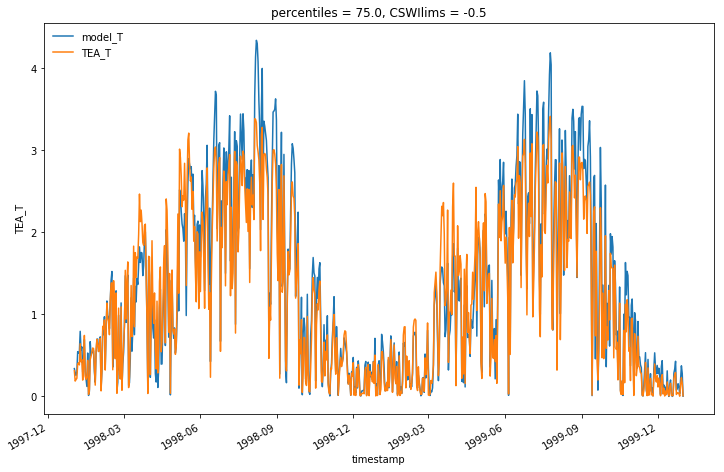

In [13]:
import matplotlib.pyplot as pl
%matplotlib inline
f, ax = pl.subplots(figsize=(12,8))
ds.ET_T.resample('D',how='sum',dim='timestamp').plot(ax=ax,label='model_T')
ds.TEA_T.sel(CSWIlims=-0.5,percentiles=75).resample('D',how='sum',dim='timestamp').plot(ax=ax, label='TEA_T')
ax.legend(loc='upper left',frameon=False)

Note that the function simplePartition is a simplified and streamlined version of this process:

In [14]:
from TEA.PreProc import simplePartition

TEA_T,TEA_E,TEA_WUE = simplePartition(timestamp, ET, GPP, RH, Rg, Rg_pot, Tair, VPD, precip, u)

/home/jnelson/anaconda3/envs/jpy/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [15]:
print(TEA_T)
print(TEA_E)
print(TEA_WUE)

[ 0.  0. -0. ... -0. -0.  0.]
[ 0.009764 -0.004045 -0.005247 ... -0.003541 -0.003472 -0.003167]
[43883.13978316 33614.16689026 59955.88235294 ... 59955.88235294
 59955.88235294 33614.16689026]


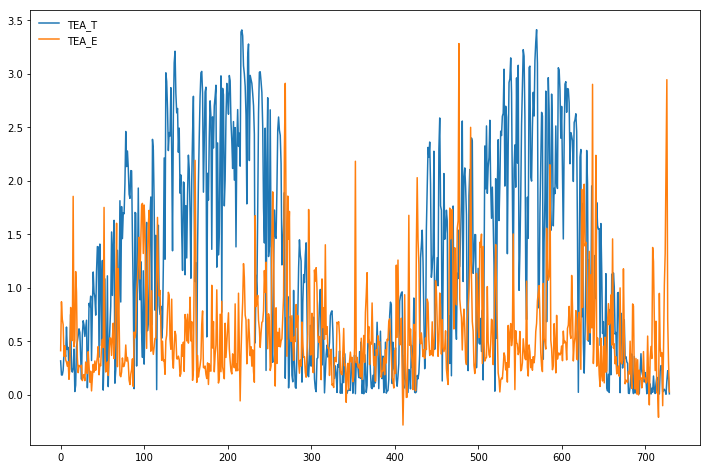

In [16]:
f, ax = pl.subplots(figsize=(12,8))
ax.plot(TEA_T.reshape(-1,48).sum(axis=1), label='TEA_T')
ax.plot(TEA_E.reshape(-1,48).sum(axis=1), label='TEA_E')
ax.legend(loc='upper left',frameon=False)